In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv("./data/market/Bhiwandi.Rice.csv")
df['Price Date'] = pd.to_datetime(df['Price Date'], format='%d %b %Y').dt.strftime('%Y-%m-%d')
df.drop(['Min Price (Rs./Quintal)','Max Price (Rs./Quintal)',], axis=1, inplace = True)
df.rename(columns={'Modal Price (Rs./Quintal)':'Price', 'Price Date': 'Date'}, inplace = True)
df.set_index('Date', inplace = True)
df.sort_index(inplace = True)
df.index = pd.to_datetime(df.index)
df

,Price
Date,
2012-03-12,2900
2012-03-29,2150
2012-04-02,2900
2012-04-09,2900
2012-04-12,2900
...,...
2021-12-15,1815
2021-12-17,1815
2021-12-20,1815


In [3]:

df = df.resample('D').first()

df['Price'].interpolate(method='pchip', inplace=True)
df

/tmp/ipykernel_9663/3950296218.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Price'].interpolate(method='pchip', inplace=True)


,Price
Date,
2012-03-12,2900.000000
2012-03-13,2775.279870
2012-03-14,2665.214736
2012-03-15,2568.888663
2012-03-16,2485.385711
...,...
2021-12-23,1815.000000
2021-12-24,1815.000000
2021-12-25,1815.000000


In [4]:
df


,Price
Date,
2012-03-12,2900.000000
2012-03-13,2775.279870
2012-03-14,2665.214736
2012-03-15,2568.888663
2012-03-16,2485.385711
...,...
2021-12-23,1815.000000
2021-12-24,1815.000000
2021-12-25,1815.000000


In [5]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Price,3578.0,2449.817583,483.632902,1400.0,2081.384058,2385.578214,2842.133415,4580.0


In [6]:
print(df['Price'].min())

1400.0


In [7]:
print(df['Price'].min())

1400.0


<Axes: xlabel='Date'>

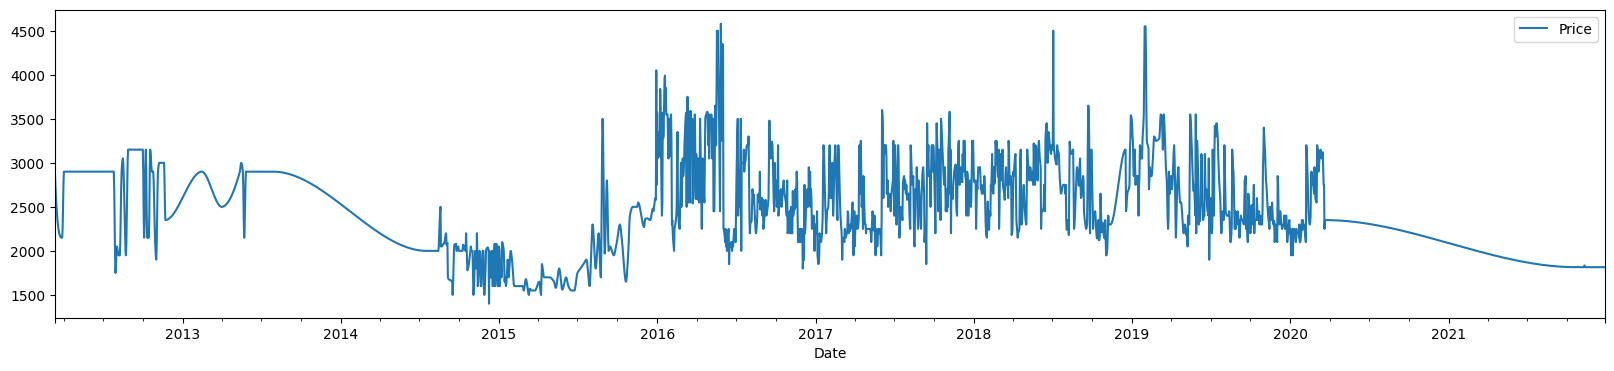

In [8]:
df.plot(figsize=(20, 4))

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [10]:
result = seasonal_decompose(df, model="multiplicative")

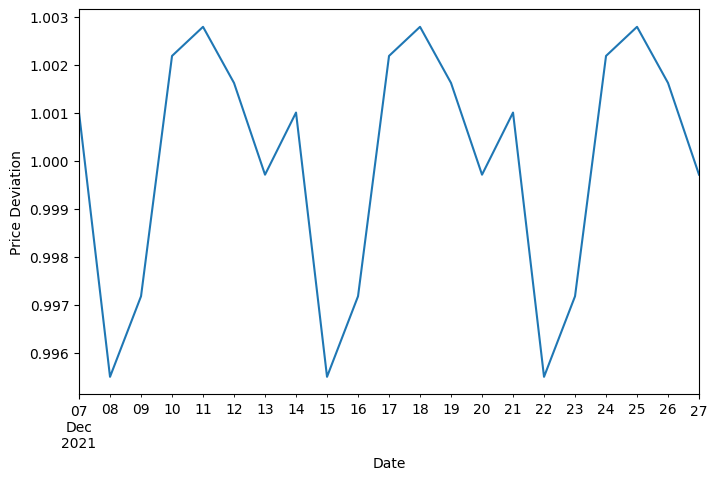

In [11]:
result.seasonal[-21:].plot(figsize=(8, 5))
plt.ylabel("Price Deviation")
plt.show()

In [12]:
PREDICTION_DAYS = 28

In [13]:
from sklearn.preprocessing import MinMaxScaler

In [14]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

In [15]:
sequence_length = 56

In [16]:
X, y = [], []

sequences = []

for i in range(len(df) - sequence_length):
    X.append(scaled_data[i:(i + sequence_length)])
    y.append(scaled_data[(i + sequence_length)][0])

X = np.array(X)
y = np.array(y)

In [17]:
X.shape, y.shape

((3522, 56, 1), (3522,))

In [18]:
split = int(0.8 * len(X))

In [19]:
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]

In [20]:
X_train.shape
y_train.shape

(2817,)

In [21]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

model = Sequential(
    [
        LSTM(units=64, return_sequences=True, activation="relu", input_shape=(X_train.shape[1], X_train.shape[2])),
        LSTM(units=64, return_sequences=False),
        Dense(units=1),
    ]
)

model.compile(optimizer="adam", loss="mean_squared_error")

2024-03-27 19:49:20.770659: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-27 19:49:20.810200: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-27 19:49:20.810237: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-27 19:49:20.811272: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-27 19:49:20.818084: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-27 19:49:20.818477: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 56, 64)            16896     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 49985 (195.25 KB)
Trainable params: 49985 (195.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [23]:
history = model.fit(X_train, y_train, batch_size=28, epochs=50, validation_data=(X_val, y_val))

Epoch 1/50


101/101 [==============================] - 11s 63ms/step - loss: 0.0136 - val_loss: 0.0011
Epoch 2/50
101/101 [==============================] - 5s 51ms/step - loss: 0.0082 - val_loss: 0.0016
Epoch 3/50
101/101 [==============================] - 6s 63ms/step - loss: 0.0073 - val_loss: 9.8550e-04
Epoch 4/50
101/101 [==============================] - 6s 57ms/step - loss: 0.0066 - val_loss: 7.0708e-04
Epoch 5/50
101/101 [==============================] - 5s 49ms/step - loss: 0.0059 - val_loss: 0.0011
Epoch 6/50
101/101 [==============================] - 6s 55ms/step - loss: 0.0054 - val_loss: 6.6301e-04
Epoch 7/50
101/101 [==============================] - 6s 57ms/step - loss: 0.0046 - val_loss: 6.6652e-04
Epoch 8/50
101/101 [==============================] - 5s 51ms/step - loss: 0.0043 - val_loss: 4.2498e-04
Epoch 9/50
101/101 [==============================] - 6s 58ms/step - loss: 0.0043 - val_loss: 7.7704e-04
Epoch 10/50
101/101 [==============================] - 6s 59ms/step - loss: 0

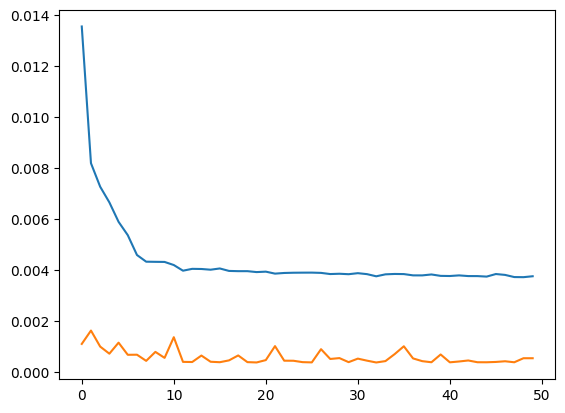

In [24]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

In [25]:
from joblib import dump, load

In [26]:
from sklearn.pipeline import Pipeline

dump(
    Pipeline([("scaler", scaler), ("model", model)]),
    "./out/forecast.LSTM.Bhiwandi.joblib",
)

['./out/forecast.LSTM.Bhiwandi.joblib']

In [27]:
x_test = scaled_data[-sequence_length:]
x_test = np.array([x_test])

In [28]:
x_test.shape

(1, 56, 1)

In [29]:
X.shape

(3522, 56, 1)

In [30]:
predictions = model.predict(X)

111/111 [==============================] - 2s 9ms/step


In [31]:
predictions = predictions.reshape(-1,1)
predictions = scaler.inverse_transform(predictions).flatten()

In [32]:
from datetime import timedelta

In [33]:
future_dates = [df.index[-1] + timedelta(days=i) for i in range(1, 29)]

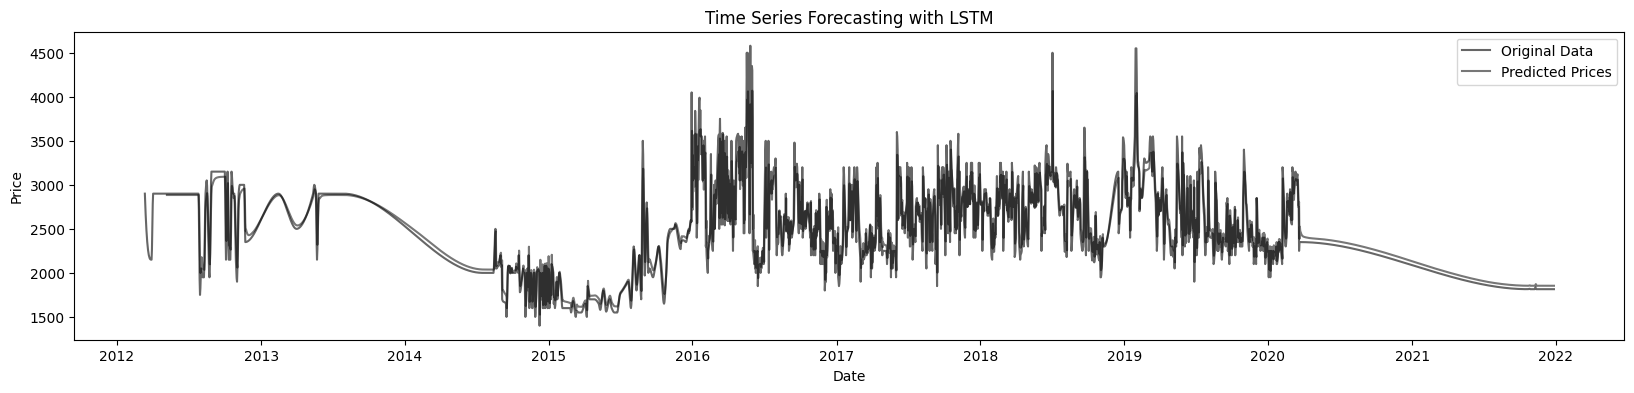

In [34]:
plt.figure(figsize=(20, 4))
plt.plot(df.index, df['Price'], label='Original Data', c="#666666")
plt.plot(df.index[sequence_length:], predictions, label='Predicted Prices', c="#00000088")
plt.title('Time Series Forecasting with LSTM')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [35]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

(
    mean_absolute_error(predictions, df["Price"][sequence_length:]),
    mean_squared_error(predictions, df["Price"][sequence_length:], squared=False),
)

/home/smv/code/fresh-fields/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


(102.24943601119271, 175.7220924578598)